# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.externals import joblib
#from sklearn.cross_validation import StratifiedKFold
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.metrics import make_scorer, f1_score, roc_auc_score

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
azdias = pd.read_csv('Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('Udacity_CUSTOMERS_052018.csv', sep=';')
azdias.head()

/data/timma/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [3]:
df_train0 = pd.read_csv('Udacity_MAILOUT_052018_TRAIN.csv', sep=';')
df_test0 = pd.read_csv('Udacity_MAILOUT_052018_TEST.csv', sep=';')
df_train0.head()

/data/timma/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,...,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [4]:
feature_summary0 = pd.read_csv('arvato_data/AZDIAS_Feature_Summary.csv', delimiter = ';')
X = 'X'
XX = 'XX'
feature_summary0['missing_or_unknown'] = feature_summary0['missing_or_unknown'].apply(lambda x: eval(x))
feature_summary0.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1, 0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1, 0, 9]"
2,ANREDE_KZ,person,categorical,"[-1, 0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [5]:
attribute_value_xls = pd.read_excel('DIAS Attributes - Values 2017.xlsx')
#attribute_value_xls.drop(columns=['Unnamed: 0'],inplace=True)
attribute_value_xls = attribute_value_xls.ffill()
attribute_value_xls.head()

,Type,Attribute,Description,Value,Meaning
0,categorical,AGER_TYP,best-ager typology,-1,unknown
1,categorical,AGER_TYP,best-ager typology,0,no classification possible
2,categorical,AGER_TYP,best-ager typology,1,passive elderly
3,categorical,AGER_TYP,best-ager typology,2,cultural elderly
4,categorical,AGER_TYP,best-ager typology,3,experience-driven elderly


In [6]:
attribute_value_xls[attribute_value_xls['Meaning'].apply(lambda x:1 if 'know' in x else 0) == 1]['Meaning'].value_counts()

unknown                                                           232
no transaction known                                               34
no transactions known                                              22
mixed building without actually known household or comapny          1
unknown / no main age detectable                                    1
mixed building without actually known company                       1
company building w/o known company                                  1
mixed building without actually known household                     1
residental building buildings without actually known household      1
Name: Meaning, dtype: int64

In [7]:
ukn_str_lst = ['unknown','no transaction known','no transactions known','unknown / no main age detectable']
attribute_value_xls[attribute_value_xls['Meaning'].apply(lambda x:1 if x in ukn_str_lst else 0) == 1]['Meaning'].value_counts()

unknown                             232
no transaction known                 34
no transactions known                22
unknown / no main age detectable      1
Name: Meaning, dtype: int64

In [8]:
undocumented_features = set(azdias.columns) - set(feature_summary0['attribute']) - set(attribute_value_xls['Attribute'])
len(undocumented_features),undocumented_features

(90,
 {'AKT_DAT_KL',
  'ALTERSKATEGORIE_FEIN',
  'ALTER_KIND1',
  'ALTER_KIND2',
  'ALTER_KIND3',
  'ALTER_KIND4',
  'ANZ_KINDER',
  'ANZ_STATISTISCHE_HAUSHALTE',
  'CJT_KATALOGNUTZER',
  'CJT_TYP_1',
  'CJT_TYP_2',
  'CJT_TYP_3',
  'CJT_TYP_4',
  'CJT_TYP_5',
  'CJT_TYP_6',
  'D19_BANKEN_DIREKT',
  'D19_BANKEN_GROSS',
  'D19_BANKEN_LOKAL',
  'D19_BANKEN_REST',
  'D19_BEKLEIDUNG_GEH',
  'D19_BEKLEIDUNG_REST',
  'D19_BILDUNG',
  'D19_BIO_OEKO',
  'D19_BUCH_CD',
  'D19_DIGIT_SERV',
  'D19_DROGERIEARTIKEL',
  'D19_ENERGIE',
  'D19_FREIZEIT',
  'D19_GARTEN',
  'D19_HANDWERK',
  'D19_HAUS_DEKO',
  'D19_KINDERARTIKEL',
  'D19_KONSUMTYP_MAX',
  'D19_KOSMETIK',
  'D19_LEBENSMITTEL',
  'D19_LETZTER_KAUF_BRANCHE',
  'D19_LOTTO',
  'D19_NAHRUNGSERGAENZUNG',
  'D19_RATGEBER',
  'D19_REISEN',
  'D19_SAMMELARTIKEL',
  'D19_SCHUHE',
  'D19_SONSTIGE',
  'D19_SOZIALES',
  'D19_TECHNIK',
  'D19_TELKO_MOBILE',
  'D19_TELKO_ONLINE_QUOTE_12',
  'D19_TELKO_REST',
  'D19_TIERARTIKEL',
  'D19_VERSAND_REST',
 

In [9]:
set(attribute_value_xls['Attribute']) - set(azdias.columns)

{'BIP_FLAG',
 'CAMEO_DEUINTL_2015',
 'D19_BANKEN_DIREKT_RZ',
 'D19_BANKEN_GROSS_RZ',
 'D19_BANKEN_LOKAL_RZ',
 'D19_BANKEN_REST_RZ',
 'D19_BEKLEIDUNG_GEH_RZ',
 'D19_BEKLEIDUNG_REST_RZ',
 'D19_BILDUNG_RZ',
 'D19_BIO_OEKO_RZ',
 'D19_BUCH_RZ',
 'D19_DIGIT_SERV_RZ',
 'D19_DROGERIEARTIKEL_RZ',
 'D19_ENERGIE_RZ',
 'D19_FREIZEIT_RZ',
 'D19_GARTEN_RZ',
 'D19_HANDWERK_RZ',
 'D19_HAUS_DEKO_RZ',
 'D19_KINDERARTIKEL_RZ',
 'D19_KK_KUNDENTYP',
 'D19_KOSMETIK_RZ',
 'D19_LEBENSMITTEL_RZ',
 'D19_LOTTO_RZ',
 'D19_NAHRUNGSERGAENZUNG_RZ',
 'D19_RATGEBER_RZ',
 'D19_REISEN_RZ',
 'D19_SAMMELARTIKEL_RZ',
 'D19_SCHUHE_RZ',
 'D19_SONSTIGE_RZ',
 'D19_TECHNIK_RZ',
 'D19_TELKO_MOBILE_RZ',
 'D19_TELKO_REST_RZ',
 'D19_TIERARTIKEL_RZ',
 'D19_VERSAND_REST_RZ',
 'D19_VERSICHERUNGEN_RZ',
 'D19_VOLLSORTIMENT_RZ',
 'D19_WEIN_FEINKOST_RZ',
 'GEOSCORE_KLS7',
 'HAUSHALTSSTRUKTUR',
 'KBA13_CCM_1400_2500',
 'SOHO_FLAG',
 'WACHSTUMSGEBIET_NB'}

In [10]:
attribute_value_xls['Attribute'] = attribute_value_xls['Attribute'].apply(lambda x: x.replace('_RZ','') if 'D19' in x else x)
undocumented_features = set(azdias.columns) - set(feature_summary0['attribute']) - set(attribute_value_xls['Attribute'])
len(undocumented_features),undocumented_features

(57,
 {'AKT_DAT_KL',
  'ALTERSKATEGORIE_FEIN',
  'ALTER_KIND1',
  'ALTER_KIND2',
  'ALTER_KIND3',
  'ALTER_KIND4',
  'ANZ_KINDER',
  'ANZ_STATISTISCHE_HAUSHALTE',
  'CJT_KATALOGNUTZER',
  'CJT_TYP_1',
  'CJT_TYP_2',
  'CJT_TYP_3',
  'CJT_TYP_4',
  'CJT_TYP_5',
  'CJT_TYP_6',
  'D19_BUCH_CD',
  'D19_KONSUMTYP_MAX',
  'D19_LETZTER_KAUF_BRANCHE',
  'D19_SOZIALES',
  'D19_TELKO_ONLINE_QUOTE_12',
  'D19_VERSI_DATUM',
  'D19_VERSI_OFFLINE_DATUM',
  'D19_VERSI_ONLINE_DATUM',
  'D19_VERSI_ONLINE_QUOTE_12',
  'DSL_FLAG',
  'EINGEFUEGT_AM',
  'EINGEZOGENAM_HH_JAHR',
  'EXTSEL992',
  'FIRMENDICHTE',
  'GEMEINDETYP',
  'HH_DELTA_FLAG',
  'KBA13_ANTG1',
  'KBA13_ANTG2',
  'KBA13_ANTG3',
  'KBA13_ANTG4',
  'KBA13_BAUMAX',
  'KBA13_CCM_1401_2500',
  'KBA13_GBZ',
  'KBA13_HHZ',
  'KBA13_KMH_210',
  'KOMBIALTER',
  'KONSUMZELLE',
  'LNR',
  'MOBI_RASTER',
  'RT_KEIN_ANREIZ',
  'RT_SCHNAEPPCHEN',
  'RT_UEBERGROESSE',
  'STRUKTURTYP',
  'UMFELD_ALT',
  'UMFELD_JUNG',
  'UNGLEICHENN_FLAG',
  'VERDICHTUNGS

In [11]:
useless_feat = list(set(attribute_value_xls['Attribute']) - set(azdias.columns))
useless_feat

['WACHSTUMSGEBIET_NB',
 'D19_BUCH',
 'SOHO_FLAG',
 'BIP_FLAG',
 'HAUSHALTSSTRUKTUR',
 'GEOSCORE_KLS7',
 'KBA13_CCM_1400_2500',
 'D19_KK_KUNDENTYP',
 'CAMEO_DEUINTL_2015']

In [12]:
attribute_value_xls = attribute_value_xls[~attribute_value_xls['Attribute'].isin(useless_feat)]
attribute_value_xls = attribute_value_xls[~attribute_value_xls['Attribute'].isin(set(feature_summary0['attribute']))]
attribute_value_xls.head()

,Type,Attribute,Description,Value,Meaning
138,ordinal,D19_BANKEN_ANZ_12,transaction activity BANKS in the last 12 months,0,no transactions known
139,ordinal,D19_BANKEN_ANZ_12,transaction activity BANKS in the last 12 months,1,very low activity
140,ordinal,D19_BANKEN_ANZ_12,transaction activity BANKS in the last 12 months,2,low activity
141,ordinal,D19_BANKEN_ANZ_12,transaction activity BANKS in the last 12 months,3,slightly increased activity
142,ordinal,D19_BANKEN_ANZ_12,transaction activity BANKS in the last 12 months,4,increased activity


In [13]:
na_att_xls = attribute_value_xls[attribute_value_xls['Meaning'].apply(lambda x:1 if x in ukn_str_lst else 0) == 1]
na_att_xls['Value'] = na_att_xls['Value'].astype(str)
na_att_xls['Value'] = na_att_xls['Value'].apply(lambda x: eval(x))
na_att_xls

/data/timma/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/data/timma/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Type,Attribute,Description,Value,Meaning
138,ordinal,D19_BANKEN_ANZ_12,transaction activity BANKS in the last 12 months,0,no transactions known
145,ordinal,D19_BANKEN_ANZ_24,transaction activity BANKS in the last 24 months,0,no transactions known
161,ordinal,D19_BANKEN_DATUM,actuality of the last transaction for the segm...,10,no transactions known
162,categorical,D19_BANKEN_DIREKT,transactional activity based on the product gr...,0,no transaction known
170,categorical,D19_BANKEN_GROSS,transactional activity based on the product gr...,0,no transaction known
178,categorical,D19_BANKEN_LOKAL,transactional activity based on the product gr...,0,no transaction known
195,ordinal,D19_BANKEN_OFFLINE_DATUM,actuality of the last transaction for the segm...,10,no transactions known
205,ordinal,D19_BANKEN_ONLINE_DATUM,actuality of the last transaction for the segm...,10,no transactions known
217,categorical,D19_BANKEN_REST,transactional activity based on the product gr...,0,no transaction known
225,categorical,D19_BEKLEIDUNG_GEH,transactional activity based on the product gr...,0,no transaction known


In [14]:
len(attribute_value_xls.Attribute.unique()),len(na_att_xls),len(na_att_xls['Attribute'].unique())

(224, 220, 220)

In [15]:
part2 = na_att_xls[['Attribute','Type','Value']].drop_duplicates().reset_index(drop=True)
part2

,Attribute,Type,Value
0,D19_BANKEN_ANZ_12,ordinal,0
1,D19_BANKEN_ANZ_24,ordinal,0
2,D19_BANKEN_DATUM,ordinal,10
3,D19_BANKEN_DIREKT,categorical,0
4,D19_BANKEN_GROSS,categorical,0
5,D19_BANKEN_LOKAL,categorical,0
6,D19_BANKEN_OFFLINE_DATUM,ordinal,10
7,D19_BANKEN_ONLINE_DATUM,ordinal,10
8,D19_BANKEN_REST,categorical,0
9,D19_BEKLEIDUNG_GEH,categorical,0


In [16]:
part3 = attribute_value_xls[~attribute_value_xls['Attribute'].isin(na_att_xls['Attribute'].unique().tolist())][['Attribute','Type']]#.drop_duplicates(inplace=True)
part3 = part3.drop_duplicates().reset_index(drop=True)
part3

,Attribute,Type
0,D19_BANKEN_ONLINE_QUOTE_12,interval
1,D19_GESAMT_ONLINE_QUOTE_12,interval
2,D19_KONSUMTYP,categorical
3,D19_VERSAND_ONLINE_QUOTE_12,interval


In [17]:
feature_summary0 = feature_summary0.rename(columns={'attribute': 'Attribute', 'missing_or_unknown': 'Value','type':'Type'})#[['Attribute','Type','Value']]
feature_summary0.head()

,Attribute,information_level,Type,Value
0,AGER_TYP,person,categorical,"[-1, 0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1, 0, 9]"
2,ANREDE_KZ,person,categorical,"[-1, 0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [18]:
part4 = pd.DataFrame()
part4['Attribute'] = list(undocumented_features)

In [19]:
feature_dict0 = pd.concat([feature_summary0,part2,part3,part4]).reset_index(drop=True)
feature_dict0.sort_values('Attribute')

/data/timma/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


,Attribute,Type,Value,information_level
0,AGER_TYP,categorical,"[-1, 0]",person
331,AKT_DAT_KL,NaN,NaN,NaN
340,ALTERSKATEGORIE_FEIN,NaN,NaN,NaN
1,ALTERSKATEGORIE_GROB,ordinal,"[-1, 0, 9]",person
43,ALTER_HH,interval,[0],household
316,ALTER_KIND1,NaN,NaN,NaN
319,ALTER_KIND2,NaN,NaN,NaN
312,ALTER_KIND3,NaN,NaN,NaN
352,ALTER_KIND4,NaN,NaN,NaN
2,ANREDE_KZ,categorical,"[-1, 0]",person


In [20]:
len(feature_dict0.Attribute.unique()),len(azdias.columns)

(366, 366)

In [21]:
set(feature_dict0.Attribute.unique())-set(azdias.columns),set(azdias.columns)-set(feature_dict0.Attribute.unique())

(set(), set())

In [22]:
feature_dict0.to_csv('feature_dict.csv')

### manual edit

In [23]:
feature_dict = pd.read_excel('feature_dict1.xlsx')
X = 'X'
XX = 'XX'
feature_dict['Value'] = feature_dict['Value'].apply(lambda x: np.nan if str(x) == 'nan' else eval(str(x)))
feature_dict

,Attribute,Type,Value,information_level
0,AGER_TYP,categorical,"[-1, 0]",person
1,AKT_DAT_KL,o,NaN,NaN
2,ALTER_HH,interval,[0],household
3,ALTER_KIND1,o,NaN,NaN
4,ALTER_KIND2,o,NaN,NaN
5,ALTER_KIND3,o,NaN,NaN
6,ALTER_KIND4,o,NaN,NaN
7,ALTERSKATEGORIE_FEIN,o0,NaN,NaN
8,ALTERSKATEGORIE_GROB,ordinal,"[-1, 0, 9]",person
9,ANREDE_KZ,categorical,"[-1, 0]",person


In [24]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!

In [25]:
def try2float(x):
    try:
        return float(x)
    except:
        return str(x)

def try2int(x):
    try:
        return int(x)
    except:
        return str(x)
    
def preproc_na_typ(df,df_dict):
    count = 0
    for index,row in df_dict.iterrows():
        count += 1
        feat = row.Attribute
        nans = row.Value
        if feat not in df.columns:
            continue
        
        if isinstance(nans, int) or isinstance(nans, float):
            df[feat] = df[feat].apply(lambda x: np.nan if x == nans else x)
        else:
            df[feat] = df[feat].apply(lambda x: np.nan if x in nans else x)
            
        if row['Type'] == 'dt':
            df[feat] = df[feat].apply(lambda x: np.nan if str(x)=='nan' else datetime.date.toordinal(datetime.datetime.strptime(str(x),"%Y-%m-%d %H:%M:%S")))
        elif row['Type'] in ['c','c0','categorical','mc']:
            df[feat] = df[feat].apply(lambda x:np.nan if str(x)=='nan' else try2int(x)).astype('category')
        else:
            df[feat] = df[feat].apply(lambda x:np.nan if str(x)=='nan' else try2int(x))
        
        if count%20 == 0:
            print(datetime.datetime.now(),'Processed:',count)
            
    return df

In [26]:
azdias1 = preproc_na_typ(azdias.copy(),feature_dict)
azdias1.head()

2019-03-22 16:00:37.809684 Processed: 20
2019-03-22 16:00:52.249083 Processed: 40
2019-03-22 16:01:06.685697 Processed: 60
2019-03-22 16:01:20.487407 Processed: 80
2019-03-22 16:01:40.708492 Processed: 100
2019-03-22 16:01:56.080833 Processed: 120
2019-03-22 16:02:10.738965 Processed: 140
2019-03-22 16:02:26.621546 Processed: 160
2019-03-22 16:02:41.813852 Processed: 180
2019-03-22 16:02:56.205408 Processed: 200
2019-03-22 16:03:10.523204 Processed: 220
2019-03-22 16:03:24.808553 Processed: 240
2019-03-22 16:03:39.077227 Processed: 260
2019-03-22 16:03:53.413151 Processed: 280
2019-03-22 16:04:07.728860 Processed: 300
2019-03-22 16:04:25.524039 Processed: 320
2019-03-22 16:04:40.271727 Processed: 340
2019-03-22 16:04:55.488879 Processed: 360


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2.0
1,910220,NaN,9.0,NaN,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1.0
2,910225,NaN,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3.0
3,910226,2.0,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4.0
4,910241,NaN,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3.0


In [27]:
null_stat = pd.concat([azdias.isnull().mean(),azdias1.isnull().mean()],axis=1)
null_stat = null_stat.reset_index()
null_stat = null_stat.rename(columns={'index':'Attribute',0:'orig', 1:'na_rate'}).sort_values('na_rate',ascending=False)
null_stat[:5]

,Attribute,orig,na_rate
7,ALTER_KIND4,0.998648,0.998648
349,TITEL_KZ,0.082470,0.997576
6,ALTER_KIND3,0.993077,0.993077
76,D19_TELKO_ONLINE_DATUM,0.000000,0.990796
33,D19_BANKEN_LOKAL,0.000000,0.981513


/data/timma/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/data/timma/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


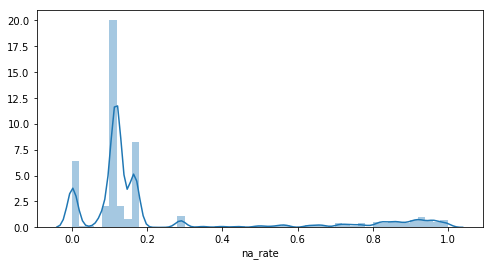

In [28]:
f,ax = plt.subplots(figsize=(8,4))
sns.distplot(null_stat['na_rate'],ax=ax)

In [29]:
azdias1['CAMEO_INTL_2015a'] = azdias1['CAMEO_INTL_2015'].apply(lambda x:np.nan if str(x)=='nan' else int(str(x)[0]))
azdias1['CAMEO_INTL_2015b'] = azdias1['CAMEO_INTL_2015'].apply(lambda x:np.nan if str(x)=='nan' else int(str(x)[1]))
len(azdias1.columns)

368

In [30]:
drop_cols = null_stat[null_stat['na_rate']>0.3]['Attribute'].tolist() 
azdias1 = azdias1.drop(drop_cols+['LNR','CAMEO_INTL_2015'],axis=1)
asdias_col0 = azdias1.columns.tolist()
len(asdias_col0)

299

/data/timma/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/data/timma/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


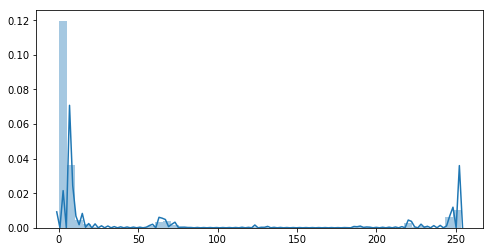

In [31]:
s1 = azdias1.isnull().sum(axis=1).sort_values(ascending=False)
f,ax = plt.subplots(figsize=(8,4))
sns.distplot(s1,ax=ax)

In [32]:
# 小于 Q1-1.5*IQR，大于 Q3+1.5*IQR 的数据则认为是异常值
#Q3 + 1.5*IQR = 8 + 1.5*(8-0) = 20
s1.describe()

count    891221.000000
mean         33.630966
std          75.996304
min           0.000000
25%           0.000000
50%           1.000000
75%           8.000000
max         253.000000
dtype: float64

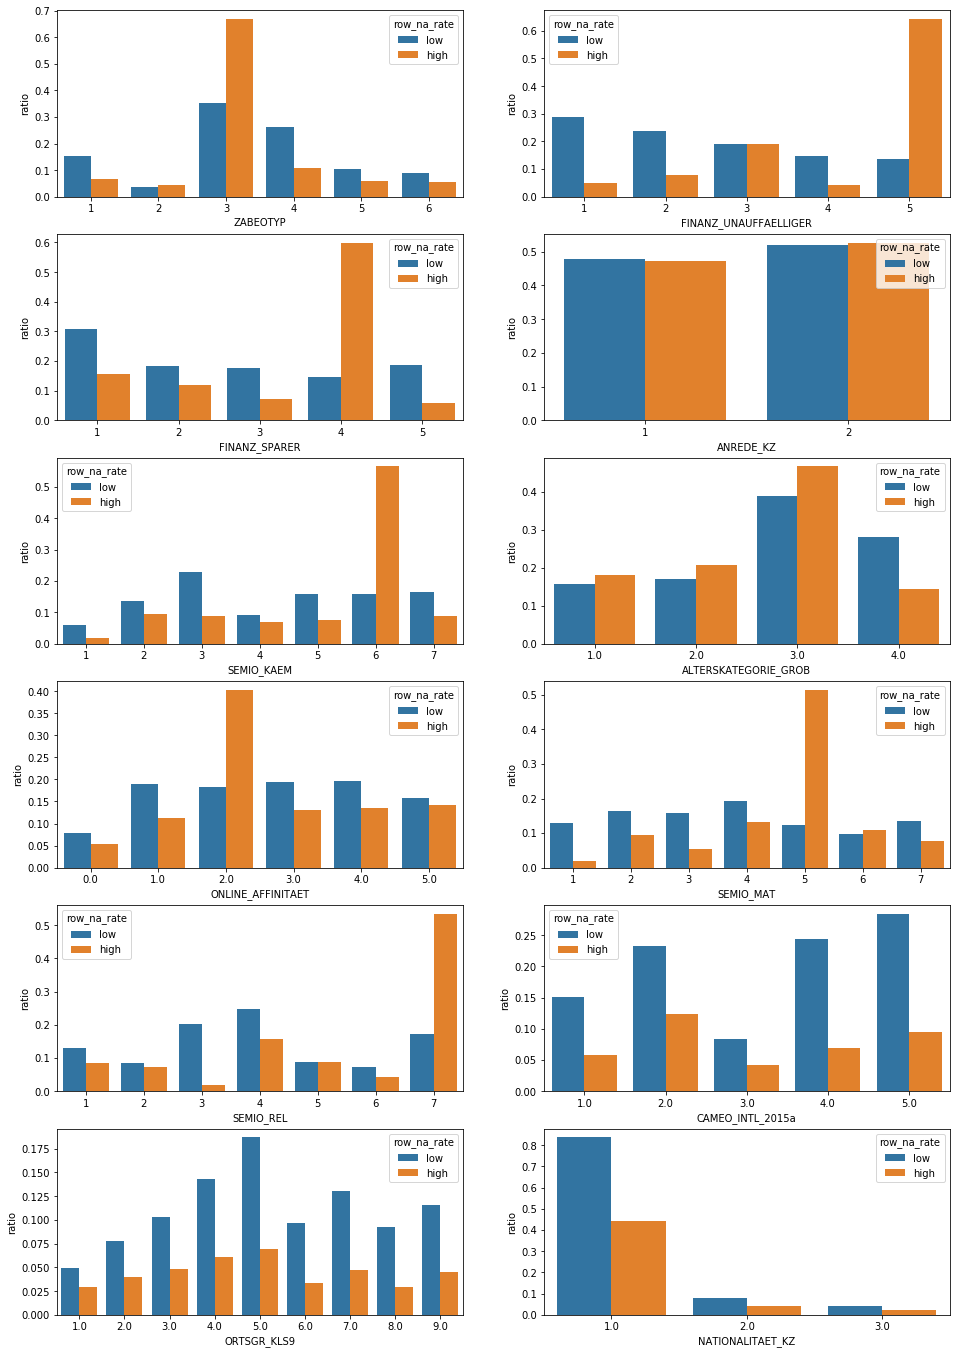

In [33]:
selected_features = ['ZABEOTYP', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_SPARER', 
                     'ANREDE_KZ', 'SEMIO_KAEM', 'ALTERSKATEGORIE_GROB', 
                     'ONLINE_AFFINITAET', 'SEMIO_MAT', 'SEMIO_REL',
                     'CAMEO_INTL_2015a', 'ORTSGR_KLS9', 'NATIONALITAET_KZ'
                    ]
nrow = 2
ncol = int(len(selected_features)/nrow)
azdias1['chk'] = azdias1.isnull().sum(axis=1).apply(lambda x:1 if x>20 else 0)

f,ax = plt.subplots(nrow,ncol,figsize = (16, 24))
for i,c in enumerate(selected_features):
    ax = plt.subplot(ncol, nrow, i+1)
    
    df0 = pd.DataFrame()
    df0['ratio'] = azdias1[azdias1['chk']==0].groupby(c).size()/len(azdias1[azdias1['chk']==0])
    df0['row_na_rate'] = 'low'
    df0 = df0.reset_index().rename(columns={c:'value'})
    
    df1 = pd.DataFrame()
    df1['ratio'] = azdias1[azdias1['chk']==1].groupby(c).size()/len(azdias1[azdias1['chk']==1])
    df1['row_na_rate'] = 'high'
    df1 = df1.reset_index().rename(columns={c:'value'})
    
    dft = pd.concat([df0,df1])
    sns.barplot(x='value',y='ratio',hue='row_na_rate',data=dft,ax=ax)
    plt.xlabel(c)
    
    #sns.countplot(x = c, hue = 'chk', data = azdias1, ax = ax)

In [34]:
azdias1 = azdias1[azdias1['chk']==0]
azdias1.drop('chk',axis=1,inplace=True)
len(azdias1.columns[azdias1.isnull().any()].tolist()),azdias1.shape

(69, (734341, 299))

In [35]:
azdias1 = pd.get_dummies(azdias1)
len(azdias1.columns[azdias1.isnull().any()].tolist()),azdias1.shape

(52, (734341, 539))

In [36]:
for i in azdias1.columns[azdias1.isnull().any()].tolist():
    top_val = azdias1.groupby(i).size().sort_values(ascending=False).index[0]
    azdias1[i].fillna(top_val, inplace=True)

In [37]:
scaler = StandardScaler()
azdias2 = azdias1.copy()
azdias2 = scaler.fit_transform(azdias2)

azdias2 = pd.DataFrame(data=azdias2, index=azdias1.index, columns=azdias1.columns)
azdias2.head()

,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,VERS_TYP_1.0,VERS_TYP_2.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,ANREDE_KZ_1,ANREDE_KZ_2
1,1.260460,1.560398,0.186421,-0.125357,-0.299106,0.223700,0.335475,-0.060624,-0.183045,0.849453,...,-0.907892,0.995192,-0.427432,-0.192365,-0.740434,-0.597351,2.948930,-0.313743,-0.958497,0.958497
2,1.260460,0.673877,0.120203,-0.125357,-0.299106,-0.635082,-0.031894,-0.060624,-0.183045,-0.980639,...,1.101452,-1.004831,-0.427432,-0.192365,-0.740434,-0.597351,2.948930,-0.313743,-0.958497,0.958497
3,-0.935447,-0.212644,-0.475767,-0.125357,-0.299106,-1.493864,-0.399263,-0.060624,-1.188897,-0.065593,...,1.101452,-1.004831,-0.427432,-0.192365,1.350559,-0.597351,-0.339106,-0.313743,-0.958497,0.958497
4,-0.935447,0.008986,-0.343329,-0.125357,-0.299106,1.941264,-0.325789,-0.060624,0.822808,-0.980639,...,-0.907892,0.995192,-0.427432,-0.192365,-0.740434,1.674059,-0.339106,-0.313743,1.043300,-1.043300
5,-0.935447,-0.877535,-0.210892,-0.125357,-0.299106,-0.635082,-0.399263,-0.060624,-1.188897,0.849453,...,-0.907892,0.995192,-0.427432,-0.192365,-0.740434,1.674059,-0.339106,-0.313743,-0.958497,0.958497


In [38]:
%%time
pca = PCA().fit(azdias2)

CPU times: user 1min 19s, sys: 1.98 s, total: 1min 21s
Wall time: 17.4 s


threshold_idx: 18


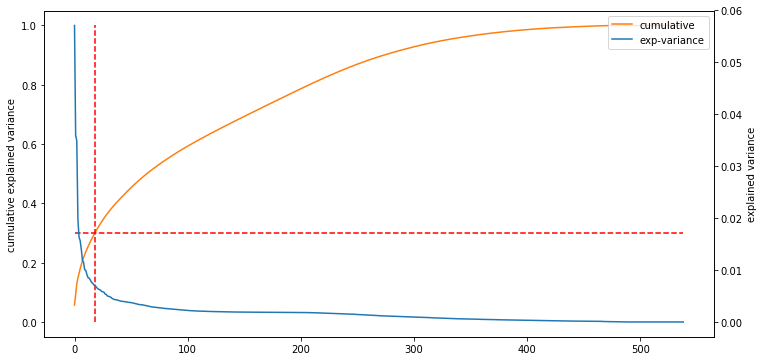

In [39]:
f,ax = plt.subplots(figsize=(12,6))
l0 = plt.plot(pca.explained_variance_ratio_.cumsum(),color=sns.color_palette()[1],label='cumulative')
plt.ylabel('cumulative explained variance')

threshold = .3
threshold_idx = np.argmin(np.abs(threshold - pca.explained_variance_ratio_.cumsum()))
print('threshold_idx:',threshold_idx)
h_line = np.ones(len(pca.explained_variance_ratio_))*threshold
y_vline = [0, 1]
x_vline = np.ones(len(y_vline))*threshold_idx
plt.plot(np.arange(len(pca.explained_variance_ratio_)), h_line, 'r--')
plt.plot(x_vline, y_vline, 'r--')

plt.twinx()
l1 = plt.plot(pca.explained_variance_ratio_,color=sns.color_palette()[0],label='exp-variance')

plt.xlabel('number of components')
plt.ylabel('explained variance')
lns = l0 + l1
labs = [l.get_label() for l in lns]
plt.legend(lns, labs, loc='best')

In [40]:
threshold_idx = np.argmin(np.abs(threshold - pca.explained_variance_ratio_.cumsum()))
threshold_idx

18

In [41]:
n_components = 20
pca20 = PCA(n_components = n_components,random_state=42)
azdias_scaled_pca = pca20.fit_transform(azdias2)
pca20.components_.shape

(20, 539)

In [42]:
def pca_detail(pca,cols,idx=0,top_features=10):
    top_idx = np.argsort(-np.abs(pca.components_[idx]))[:top_features]
    x = cols[top_idx]
    y = pca20.components_[idx][top_idx]
    df = pd.DataFrame()
    df['features'] = x
    df['weights'] = y
    print('PCA Dimension',idx,':')
    display(df.T)
    fig = plt.barh(cols[top_idx][::-1],pca20.components_[idx][top_idx][::-1])
    return fig 

PCA Dimension 0 :


,0,1,2,3,4,5,6,7,8,9
features,MOBI_REGIO,PLZ8_ANTG1,KBA13_ANTG1,PLZ8_ANTG3,KBA13_ANTG3,KBA05_ANTG1,LP_STATUS_GROB_1.0,KBA13_ANTG4,KBA13_BAUMAX,PLZ8_ANTG4
weights,-0.143068,-0.137414,-0.136721,0.135768,0.134916,-0.133355,0.132165,0.132038,0.131283,0.130747


<BarContainer object of 10 artists>

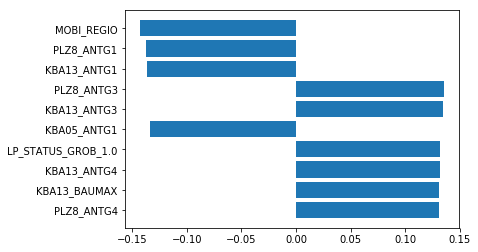

In [43]:
pca_detail(pca20,azdias2.columns)

* moving mobility(mobi): high (neg)
* num of 1-2 family houses(antg1): low (neg)
* num of 6-10 family houses(antg3): high (pos)
* num of >10 family houses(antg4): high (pos)
* social status(LP_STATUS_GROB): low-income (pos:1)
* most common building type(BAUMAX): more family-homes or business buildings (pos)

high mobility, large family area, crowed area, low-income

PCA Dimension 1 :


,0,1,2,3,4,5,6,7,8,9
features,KBA13_HERST_BMW_BENZ,KBA13_SEG_OBEREMITTELKLASSE,KBA13_MERCEDES,KBA13_SITZE_5,KBA13_BMW,KBA13_SITZE_4,KBA13_SEG_SPORTWAGEN,KBA05_HERST1,KBA13_KMH_140_210,KBA13_SEG_KLEINWAGEN
weights,0.175052,0.150754,0.149727,-0.146447,0.146139,0.144331,0.136818,0.12516,-0.122488,-0.121591


<BarContainer object of 10 artists>

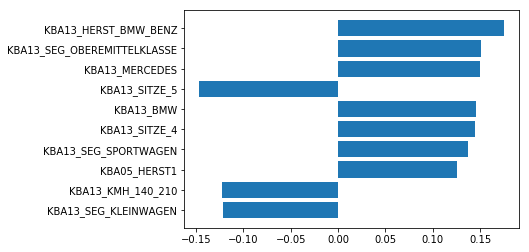

In [44]:
pca_detail(pca20,azdias2.columns,1)

* BMW & BENZ share: high (pos)
* mid & upper class cars share: high (pos)
* MERCEDES share: high (pos)
* num of 5 seat cars(sitze_5): low (neg)
* bmw share: high (pos)
* num of less than 5 seat cars: high (pos)
* sportscars share: high (pos)
* top German manufacturer: high (pos)
* max speed 140-210km/h cars share: low (neg)
* small cars share: low (neg) 

upper class cars, fast sports cars, German cars

PCA Dimension 2 :


,0,1,2,3,4,5,6,7,8,9
features,CJT_TYP_1,FINANZ_SPARER,CJT_TYP_2,ALTERSKATEGORIE_GROB,FINANZ_VORSORGER,FINANZ_UNAUFFAELLIGER,CJT_TYP_5,FINANZ_ANLEGER,CJT_TYP_4,SEMIO_PFLICHT
weights,-0.184918,-0.183318,-0.178912,0.174045,0.173939,-0.168233,0.166972,-0.164744,0.161517,-0.15814


<BarContainer object of 10 artists>

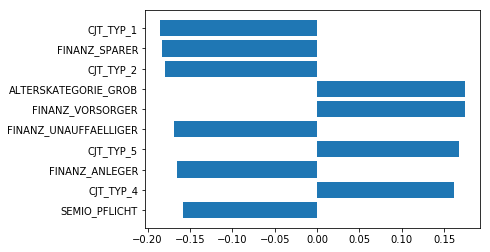

In [45]:
pca_detail(pca20,azdias2.columns,2)

* Advertising- and Consumption minimalist(CJT_TYP_1): low (neg)
* money saver(FINANZ_SPARER): no/low (neg)
* Advertising- and Consumption traditionalist(CJT_TYP_2): low (neg)
* age classification(ALTERSKATEGORIE_GROB): old (pos)
* financial type be prepared: low (pos)
* financial type unremarkable: high (neg)
* Advertising- and Cross-Channel-Enthusiast(CJT_TYP_5): high (pos)
* financial type investor: high (neg)
* advertising interested Online-shopper(CJT_TYP_4): high (pos)
* dutyfull traditional minded: high (neg)

active buyer, not young and not poor

PCA Dimension 3 :


,0,1,2,3,4,5,6,7,8,9
features,VK_DISTANZ,VK_DHT4A,VK_ZG11,LP_FAMILIE_GROB_1.0,LP_FAMILIE_FEIN_1.0,D19_KONSUMTYP_MAX,ONLINE_AFFINITAET,ANZ_PERSONEN,D19_GESAMT_ONLINE_QUOTE_12,D19_VERSAND_ONLINE_QUOTE_12
weights,-0.186304,-0.17774,-0.168033,-0.15476,-0.15476,-0.151132,0.148316,0.138614,0.131182,0.126564


<BarContainer object of 10 artists>

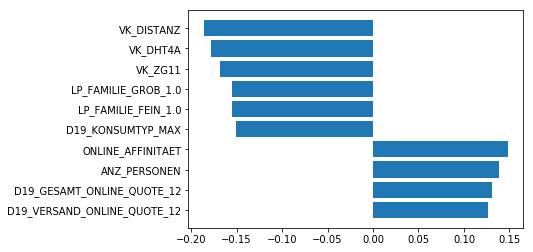

In [46]:
pca_detail(pca20,azdias2.columns,3)

* VK?
* family type single(LP_FAMILIE_FEIN,LP_FAMILIE_GROB): no (neg)
* consumption type max?
* online affinity: high (pos)
* num adult in household: many (pos)
* amount of online transaction in the complete file: high (pos)
* amount of online transaction in the segment mail-order: high (pos)

online activity, large family (not single)

In [47]:
batch_size = int(len(azdias_scaled_pca)*.01)
print(batch_size)

scores = []
for i in range(45):
    km = MiniBatchKMeans(n_clusters = i+1, batch_size = batch_size)
    km.fit(azdias_scaled_pca)
    
    scores.append(np.abs(km.score(azdias_scaled_pca)))
    print(i,km.score(azdias_scaled_pca))

7343
0 -121521694.30872127
1 -104719023.26347448
2 -98684331.32059664
3 -93511502.915616
4 -90169374.06329995
5 -85791249.9681243
6 -83796359.80137673
7 -82044404.33907713
8 -80621633.209289
9 -79235738.31396139
10 -76654401.23453023
11 -74139301.64640516
12 -75444277.12841773
13 -72690779.76862264
14 -72633389.58453268
15 -73080493.20513178
16 -70256211.87190984
17 -69582272.41026011
18 -68942150.1852828
19 -68383851.84982063
20 -68172413.47291078
21 -67231566.23619406
22 -67028353.71415649
23 -66188153.77997121
24 -66082658.938736886
25 -65036001.79300838
26 -65176007.81407995
27 -64686205.75809844
28 -64343873.82780053
29 -64140838.00751183
30 -63001207.70389636
31 -62736118.866308115
32 -62951128.39145969
33 -62519291.055247165
34 -62106540.66031773
35 -61895677.5583391
36 -61541858.373947404
37 -61382415.7867792
38 -60925817.15975464
39 -60652700.93811302
40 -60458887.63202209
41 -60228722.94922738
42 -59787471.85280573
43 -59525022.66284586
44 -59423035.22188902


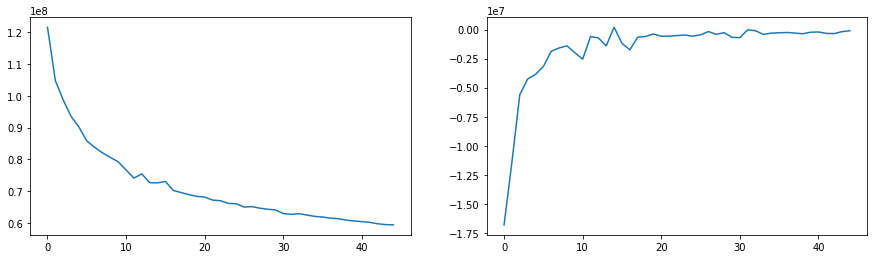

In [48]:
f,ax = plt.subplots(figsize=(15,4))

ax = plt.subplot(1,2,1)
plt.plot(scores)

ax = plt.subplot(1,2,2)
plt.plot(np.gradient(scores))

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [58]:
def clean_data(df,df_dict,col_list=asdias_col0):
    # clean data type issues for each column
    df = preproc_na_typ(df,df_dict)

    # feature engineering on CAMEO_INTL_2015
    df['CAMEO_INTL_2015a'] = df['CAMEO_INTL_2015'].apply(lambda x:np.nan if str(x)=='nan' else int(str(x)[0]))
    df['CAMEO_INTL_2015b'] = df['CAMEO_INTL_2015'].apply(lambda x:np.nan if str(x)=='nan' else int(str(x)[1]))
    
    # drop null columns that already confirmed before
    df = df[col_list]
    
    # remove null rows
    df['chk'] = df.isnull().sum(axis=1).apply(lambda x:1 if x>20 else 0)
    df = df[df['chk']==0]
    df.drop('chk',axis=1,inplace=True)
        
    # one-hot encode for category columns
    df = pd.get_dummies(df)
    
    # fill na with most frequent values
    for i in df.columns[df.isnull().any()].tolist():
        top_val = df.groupby(i).size().sort_values(ascending=False).index[0]
        df[i].fillna(top_val, inplace=True)
            
    return df

In [59]:
df_a = clean_data(azdias.copy(),feature_dict)
df_c = clean_data(customers.copy(),feature_dict)

for i in list(set(df_a.columns)-set(df_c.columns)):
    df_c[i] = 0
df_c = df_c[df_a.columns]

df_a.head()

2019-03-22 16:17:48.578856 Processed: 20
2019-03-22 16:18:03.000062 Processed: 40
2019-03-22 16:18:17.403905 Processed: 60
2019-03-22 16:18:31.714803 Processed: 80
2019-03-22 16:18:52.232844 Processed: 100
2019-03-22 16:19:07.695621 Processed: 120
2019-03-22 16:19:22.368072 Processed: 140
2019-03-22 16:19:38.302768 Processed: 160
2019-03-22 16:19:53.489618 Processed: 180
2019-03-22 16:20:07.936988 Processed: 200
2019-03-22 16:20:22.301968 Processed: 220
2019-03-22 16:20:36.625494 Processed: 240
2019-03-22 16:20:50.956983 Processed: 260
2019-03-22 16:21:05.319705 Processed: 280
2019-03-22 16:21:19.677314 Processed: 300
2019-03-22 16:21:37.567024 Processed: 320
2019-03-22 16:21:52.392993 Processed: 340
2019-03-22 16:22:07.754996 Processed: 360


/data/timma/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


2019-03-22 16:22:31.800566 Processed: 20
2019-03-22 16:22:34.818238 Processed: 40
2019-03-22 16:22:37.883164 Processed: 60
2019-03-22 16:22:40.947108 Processed: 80
2019-03-22 16:22:45.056407 Processed: 100
2019-03-22 16:22:48.283933 Processed: 120
2019-03-22 16:22:51.249808 Processed: 140
2019-03-22 16:22:54.476756 Processed: 160
2019-03-22 16:22:57.561431 Processed: 180
2019-03-22 16:23:00.487734 Processed: 200
2019-03-22 16:23:03.393215 Processed: 220
2019-03-22 16:23:06.291781 Processed: 240
2019-03-22 16:23:09.193147 Processed: 260
2019-03-22 16:23:12.098932 Processed: 280
2019-03-22 16:23:15.005242 Processed: 300
2019-03-22 16:23:18.641102 Processed: 320
2019-03-22 16:23:21.717091 Processed: 340
2019-03-22 16:23:24.896969 Processed: 360


,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,VERS_TYP_1.0,VERS_TYP_2.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,ANREDE_KZ_1,ANREDE_KZ_2
1,9.0,21.0,11.0,0.0,0.0,2.0,12.0,0.0,3.0,6.0,...,0,1,0,0,0,0,1,0,0,1
2,9.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,3.0,2.0,...,1,0,0,0,0,0,1,0,0,1
3,1.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,4.0,...,1,0,0,0,1,0,0,0,0,1
4,1.0,14.0,3.0,0.0,0.0,4.0,3.0,0.0,4.0,2.0,...,0,1,0,0,0,1,0,0,1,0
5,1.0,10.0,5.0,0.0,0.0,1.0,2.0,0.0,2.0,6.0,...,0,1,0,0,0,1,0,0,0,1


In [60]:
df_a.shape,df_c.shape

((734341, 539), (132697, 539))

In [61]:
set(df_a.columns)-set(df_c.columns),set(df_c.columns)-set(df_a.columns)

(set(), set())

In [62]:
scaler = StandardScaler()
data_a2 = scaler.fit_transform(df_a)

df_a2 = pd.DataFrame(data=data_a2, index=df_a.index, columns=df_a.columns)
df_a2.head()

,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,VERS_TYP_1.0,VERS_TYP_2.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,ANREDE_KZ_1,ANREDE_KZ_2
1,1.260460,1.560398,0.186421,-0.125357,-0.299106,0.223700,0.335475,-0.060624,-0.183045,0.849453,...,-0.907892,0.995192,-0.427432,-0.192365,-0.740434,-0.597351,2.948930,-0.313743,-0.958497,0.958497
2,1.260460,0.673877,0.120203,-0.125357,-0.299106,-0.635082,-0.031894,-0.060624,-0.183045,-0.980639,...,1.101452,-1.004831,-0.427432,-0.192365,-0.740434,-0.597351,2.948930,-0.313743,-0.958497,0.958497
3,-0.935447,-0.212644,-0.475767,-0.125357,-0.299106,-1.493864,-0.399263,-0.060624,-1.188897,-0.065593,...,1.101452,-1.004831,-0.427432,-0.192365,1.350559,-0.597351,-0.339106,-0.313743,-0.958497,0.958497
4,-0.935447,0.008986,-0.343329,-0.125357,-0.299106,1.941264,-0.325789,-0.060624,0.822808,-0.980639,...,-0.907892,0.995192,-0.427432,-0.192365,-0.740434,1.674059,-0.339106,-0.313743,1.043300,-1.043300
5,-0.935447,-0.877535,-0.210892,-0.125357,-0.299106,-0.635082,-0.399263,-0.060624,-1.188897,0.849453,...,-0.907892,0.995192,-0.427432,-0.192365,-0.740434,1.674059,-0.339106,-0.313743,-0.958497,0.958497


In [63]:
n_components = 20
pca20 = PCA(n_components = n_components,random_state=42)
df_a2_pca = pca20.fit_transform(df_a2)
pca20.components_.shape

(20, 539)

In [64]:
km = KMeans(n_clusters = 10, random_state = 42)
km.fit(df_a2_pca)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)

In [65]:
#df_c2 = pd.DataFrame(data=scaler.transform(df_c), index=df_c.index, columns=df_c.columns)
#df_c2_pca = pca20.transform(df_c2)
#df_c2_pca.shape

In [66]:
def cluster_predict(df0,scaler,pca,km):
    df = pd.DataFrame(data=scaler.transform(df0.copy()), index=df0.index, columns=df0.columns)
    df = pca.transform(df)
    df0['cluster'] = km.predict(df)
    return df0

In [67]:
df_a = cluster_predict(df_a,scaler,pca20,km)
df_c = cluster_predict(df_c,scaler,pca20,km)

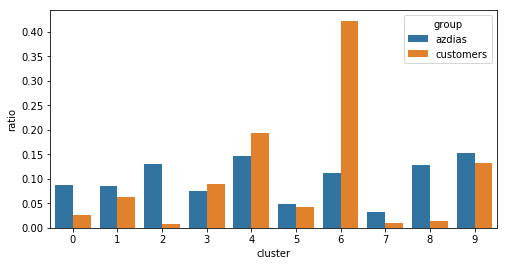

In [68]:
f,ax = plt.subplots(figsize=(8,4))
dfa = pd.DataFrame()
dfa['ratio'] = df_a.groupby('cluster').size()/len(df_a)
dfa['group'] = 'azdias'
dfa = dfa.reset_index()

dfc = pd.DataFrame()
dfc['ratio'] = df_c.groupby('cluster').size()/len(df_c)
dfc['group'] = 'customers'
dfc = dfc.reset_index()

dft = pd.concat([dfa,dfc])
sns.barplot(x='cluster',y='ratio',hue='group',data=dft,ax=ax)

In [82]:
km.cluster_centers_[6]

array([-6.17289942,  2.63805489,  2.70218727,  2.11186244, -0.41675311,
        0.17865808, -1.31227726, -1.44491091,  0.05423131,  0.52463946,
       -0.45466946, -1.3525295 , -1.34697778, -0.24049789,  1.08152205,
        0.20592145,  0.26576592,  0.76973664,  0.76512887,  0.17711268])

PCA Dimension 0 :


,0,1,2,3,4,5,6,7,8,9
features,MOBI_REGIO,PLZ8_ANTG1,KBA13_ANTG1,PLZ8_ANTG3,KBA13_ANTG3,KBA05_ANTG1,LP_STATUS_GROB_1.0,KBA13_ANTG4,KBA13_BAUMAX,PLZ8_ANTG4
weights,-0.143068,-0.137414,-0.136721,0.135768,0.134916,-0.133355,0.132165,0.132038,0.131283,0.130747


<BarContainer object of 10 artists>

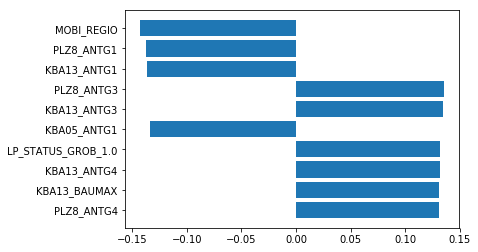

In [69]:
pca_detail(pca20,azdias2.columns,0)

PCA Dimension 1 :


,0,1,2,3,4,5,6,7,8,9
features,KBA13_HERST_BMW_BENZ,KBA13_SEG_OBEREMITTELKLASSE,KBA13_MERCEDES,KBA13_SITZE_5,KBA13_BMW,KBA13_SITZE_4,KBA13_SEG_SPORTWAGEN,KBA05_HERST1,KBA13_KMH_140_210,KBA13_SEG_KLEINWAGEN
weights,0.175052,0.150754,0.149727,-0.146447,0.146139,0.144331,0.136818,0.12516,-0.122488,-0.121591


<BarContainer object of 10 artists>

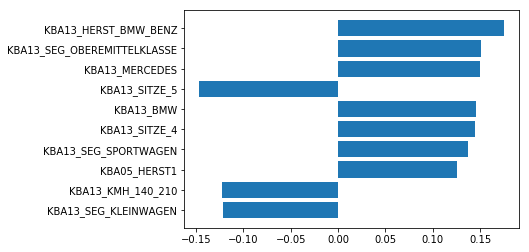

In [70]:
pca_detail(pca20,azdias2.columns,1)

PCA Dimension 2 :


,0,1,2,3,4,5,6,7,8,9
features,CJT_TYP_1,FINANZ_SPARER,CJT_TYP_2,ALTERSKATEGORIE_GROB,FINANZ_VORSORGER,FINANZ_UNAUFFAELLIGER,CJT_TYP_5,FINANZ_ANLEGER,CJT_TYP_4,SEMIO_PFLICHT
weights,-0.184918,-0.183318,-0.178912,0.174045,0.173939,-0.168233,0.166972,-0.164744,0.161517,-0.15814


<BarContainer object of 10 artists>

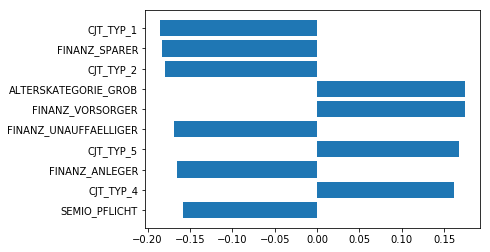

In [71]:
pca_detail(pca20,azdias2.columns,2)

PCA Dimension 3 :


,0,1,2,3,4,5,6,7,8,9
features,VK_DISTANZ,VK_DHT4A,VK_ZG11,LP_FAMILIE_GROB_1.0,LP_FAMILIE_FEIN_1.0,D19_KONSUMTYP_MAX,ONLINE_AFFINITAET,ANZ_PERSONEN,D19_GESAMT_ONLINE_QUOTE_12,D19_VERSAND_ONLINE_QUOTE_12
weights,-0.186304,-0.17774,-0.168033,-0.15476,-0.15476,-0.151132,0.148316,0.138614,0.131182,0.126564


<BarContainer object of 10 artists>

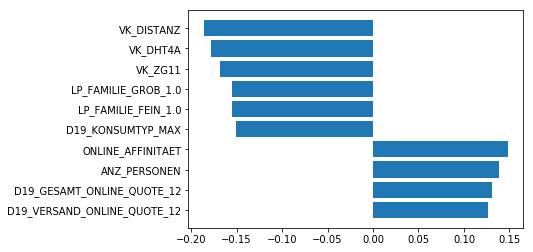

In [72]:
pca_detail(pca20,azdias2.columns,3)

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
#mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
#mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

In [83]:
def preproc_data(df,df_dict):
    # clean data type issues for each column
    df = preproc_na_typ(df,df_dict)
    
    df['CAMEO_INTL_2015a'] = df['CAMEO_INTL_2015'].apply(lambda x:np.nan if str(x)=='nan' else int(str(x)[0]))
    df['CAMEO_INTL_2015b'] = df['CAMEO_INTL_2015'].apply(lambda x:np.nan if str(x)=='nan' else int(str(x)[1]))
    df = df.drop(['CAMEO_INTL_2015'],axis=1)
    
    df = pd.get_dummies(df)
    return df

In [84]:
df_train = preproc_data(df_train0.copy(),feature_dict)#clean_data(df_train.copy(),feature_dict,ptype='train')
df_test = preproc_data(df_test0.copy(),feature_dict)#clean_data(df_test.copy(),feature_dict,ptype='train')

2019-03-22 16:28:56.267942 Processed: 20
2019-03-22 16:28:56.967009 Processed: 40
2019-03-22 16:28:57.675035 Processed: 60
2019-03-22 16:28:58.392812 Processed: 80
2019-03-22 16:28:59.381734 Processed: 100
2019-03-22 16:29:00.134949 Processed: 120
2019-03-22 16:29:00.834308 Processed: 140
2019-03-22 16:29:01.596920 Processed: 160
2019-03-22 16:29:02.324914 Processed: 180
2019-03-22 16:29:03.019826 Processed: 200
2019-03-22 16:29:03.701898 Processed: 220
2019-03-22 16:29:04.383380 Processed: 240
2019-03-22 16:29:05.065032 Processed: 260
2019-03-22 16:29:05.748092 Processed: 280
2019-03-22 16:29:06.430745 Processed: 300
2019-03-22 16:29:07.280415 Processed: 320
2019-03-22 16:29:07.993565 Processed: 340
2019-03-22 16:29:08.733152 Processed: 360
2019-03-22 16:29:10.018036 Processed: 20
2019-03-22 16:29:10.703468 Processed: 40
2019-03-22 16:29:11.411943 Processed: 60
2019-03-22 16:29:12.130749 Processed: 80
2019-03-22 16:29:13.115241 Processed: 100
2019-03-22 16:29:13.862417 Processed: 120


In [85]:
list(set(df_train.columns)-set(df_test.columns)),list(set(df_test.columns)-set(df_train.columns))

(['D19_HANDWERK_1.0', 'D19_LOTTO_4.0', 'RESPONSE'], ['D19_BIO_OEKO_1.0'])

In [86]:
for i in list(set(df_train.columns)-set(df_test.columns)):
    if i == 'RESPONSE':
        continue
    df_train = df_train.drop([i],axis=1)
    
for i in list(set(df_test.columns)-set(df_train.columns)):
    df_test = df_test.drop([i],axis=1)

In [90]:
list(set(df_train.columns)-set(df_test.columns)),list(set(df_test.columns)-set(df_train.columns))

(['RESPONSE'], [])

In [87]:
df_train = df_train.merge(customers[['LNR','CUSTOMER_GROUP','ONLINE_PURCHASE','PRODUCT_GROUP']],how='left',on='LNR')
df_train.shape

(42962, 817)

In [88]:
df_test = df_test.merge(customers[['LNR','CUSTOMER_GROUP','ONLINE_PURCHASE','PRODUCT_GROUP']],how='left',on='LNR')
df_test.shape

(42833, 816)

In [89]:
df_train['CUSTOMER_GROUP'] = df_train['CUSTOMER_GROUP'].apply(lambda x:1 if x=='SINGLE_BUYER' else 0)
df_test['CUSTOMER_GROUP'] = df_test['CUSTOMER_GROUP'].apply(lambda x:1 if x=='SINGLE_BUYER' else 0)
df_train['PRODUCT_GROUP1'] = df_train['PRODUCT_GROUP'].apply(lambda x:1 if 'FOOD' in x else 0)
df_train['PRODUCT_GROUP2'] = df_train['PRODUCT_GROUP'].apply(lambda x:1 if 'COSMETIC' in x else 0)
df_test['PRODUCT_GROUP1'] = df_test['PRODUCT_GROUP'].apply(lambda x:1 if 'FOOD' in x else 0)
df_test['PRODUCT_GROUP2'] = df_test['PRODUCT_GROUP'].apply(lambda x:1 if 'COSMETIC' in x else 0)
df_train = df_train.drop(['PRODUCT_GROUP'],axis=1)
df_test = df_test.drop(['PRODUCT_GROUP'],axis=1)
df_train[['LNR','CUSTOMER_GROUP','ONLINE_PURCHASE','PRODUCT_GROUP1','PRODUCT_GROUP2']].head()

,LNR,CUSTOMER_GROUP,ONLINE_PURCHASE,PRODUCT_GROUP1,PRODUCT_GROUP2
0,1763,0,0,1,1
1,1771,0,0,1,1
2,1776,0,1,1,1
3,1460,0,0,1,1
4,1783,0,0,1,1


In [91]:
list(set(df_train.columns)-set(df_test.columns)),list(set(df_test.columns)-set(df_train.columns))

(['RESPONSE'], [])

In [92]:
df_train['RESPONSE'].value_counts()

0    42430
1      532
Name: RESPONSE, dtype: int64

In [93]:
y = df_train['RESPONSE']
X = df_train.drop(['RESPONSE'], axis=1)
print(X.shape, y.shape)

(42962, 817) (42962,)


In [94]:
X.columns

Index(['LNR', 'AKT_DAT_KL', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2',
       'ALTER_KIND3', 'ALTER_KIND4', 'ALTERSKATEGORIE_FEIN',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL',
       ...
       'ZABEOTYP_3', 'ZABEOTYP_4', 'ZABEOTYP_5', 'ZABEOTYP_6', 'ANREDE_KZ_1',
       'ANREDE_KZ_2', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP1',
       'PRODUCT_GROUP2'],
      dtype='object', length=817)

In [95]:
train_cols = X.columns[1:]
train_cols

Index(['AKT_DAT_KL', 'ALTER_HH', 'ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3',
       'ALTER_KIND4', 'ALTERSKATEGORIE_FEIN', 'ANZ_HAUSHALTE_AKTIV',
       'ANZ_HH_TITEL', 'ANZ_KINDER',
       ...
       'ZABEOTYP_3', 'ZABEOTYP_4', 'ZABEOTYP_5', 'ZABEOTYP_6', 'ANREDE_KZ_1',
       'ANREDE_KZ_2', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP1',
       'PRODUCT_GROUP2'],
      dtype='object', length=816)

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X[train_cols], y, random_state=42, test_size=0.2)

In [97]:
clf = XGBClassifier(verbose=1)

In [98]:
%%time
clf.fit(X_train, 
        y_train, 
        eval_metric='auc', 
        verbose=True, 
        eval_set=[(X_test, y_test)], 
        early_stopping_rounds=50
       )

[0]	validation_0-auc:0.718064
Will train until validation_0-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.717358
[2]	validation_0-auc:0.717358
[3]	validation_0-auc:0.715453
[4]	validation_0-auc:0.715453
[5]	validation_0-auc:0.715453
[6]	validation_0-auc:0.74171
[7]	validation_0-auc:0.74171
[8]	validation_0-auc:0.74702
[9]	validation_0-auc:0.74702
[10]	validation_0-auc:0.74702
[11]	validation_0-auc:0.748258
[12]	validation_0-auc:0.747145
[13]	validation_0-auc:0.746363
[14]	validation_0-auc:0.746369
[15]	validation_0-auc:0.747127
[16]	validation_0-auc:0.746907
[17]	validation_0-auc:0.745236
[18]	validation_0-auc:0.745003
[19]	validation_0-auc:0.745891
[20]	validation_0-auc:0.745959
[21]	validation_0-auc:0.747821
[22]	validation_0-auc:0.747524
[23]	validation_0-auc:0.747656
[24]	validation_0-auc:0.74906
[25]	validation_0-auc:0.753266
[26]	validation_0-auc:0.753109
[27]	validation_0-auc:0.752514
[28]	validation_0-auc:0.754674
[29]	validation_0-auc:0.755884
[30]	validation_0-auc:

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1, verbose=1)

In [99]:
clf.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': True,
 'subsample': 1,
 'verbose': 1}

In [101]:
y_test_final = clf.predict_proba(df_test[train_cols])[:, 1]
y_test_final

array([0.03104344, 0.03336287, 0.00540125, ..., 0.02075526, 0.03793916,
       0.0316454 ], dtype=float32)

In [102]:
df_test['RESPONSE'] = y_test_final
df_test[['LNR', 'RESPONSE']].to_csv('response.csv', index=False)

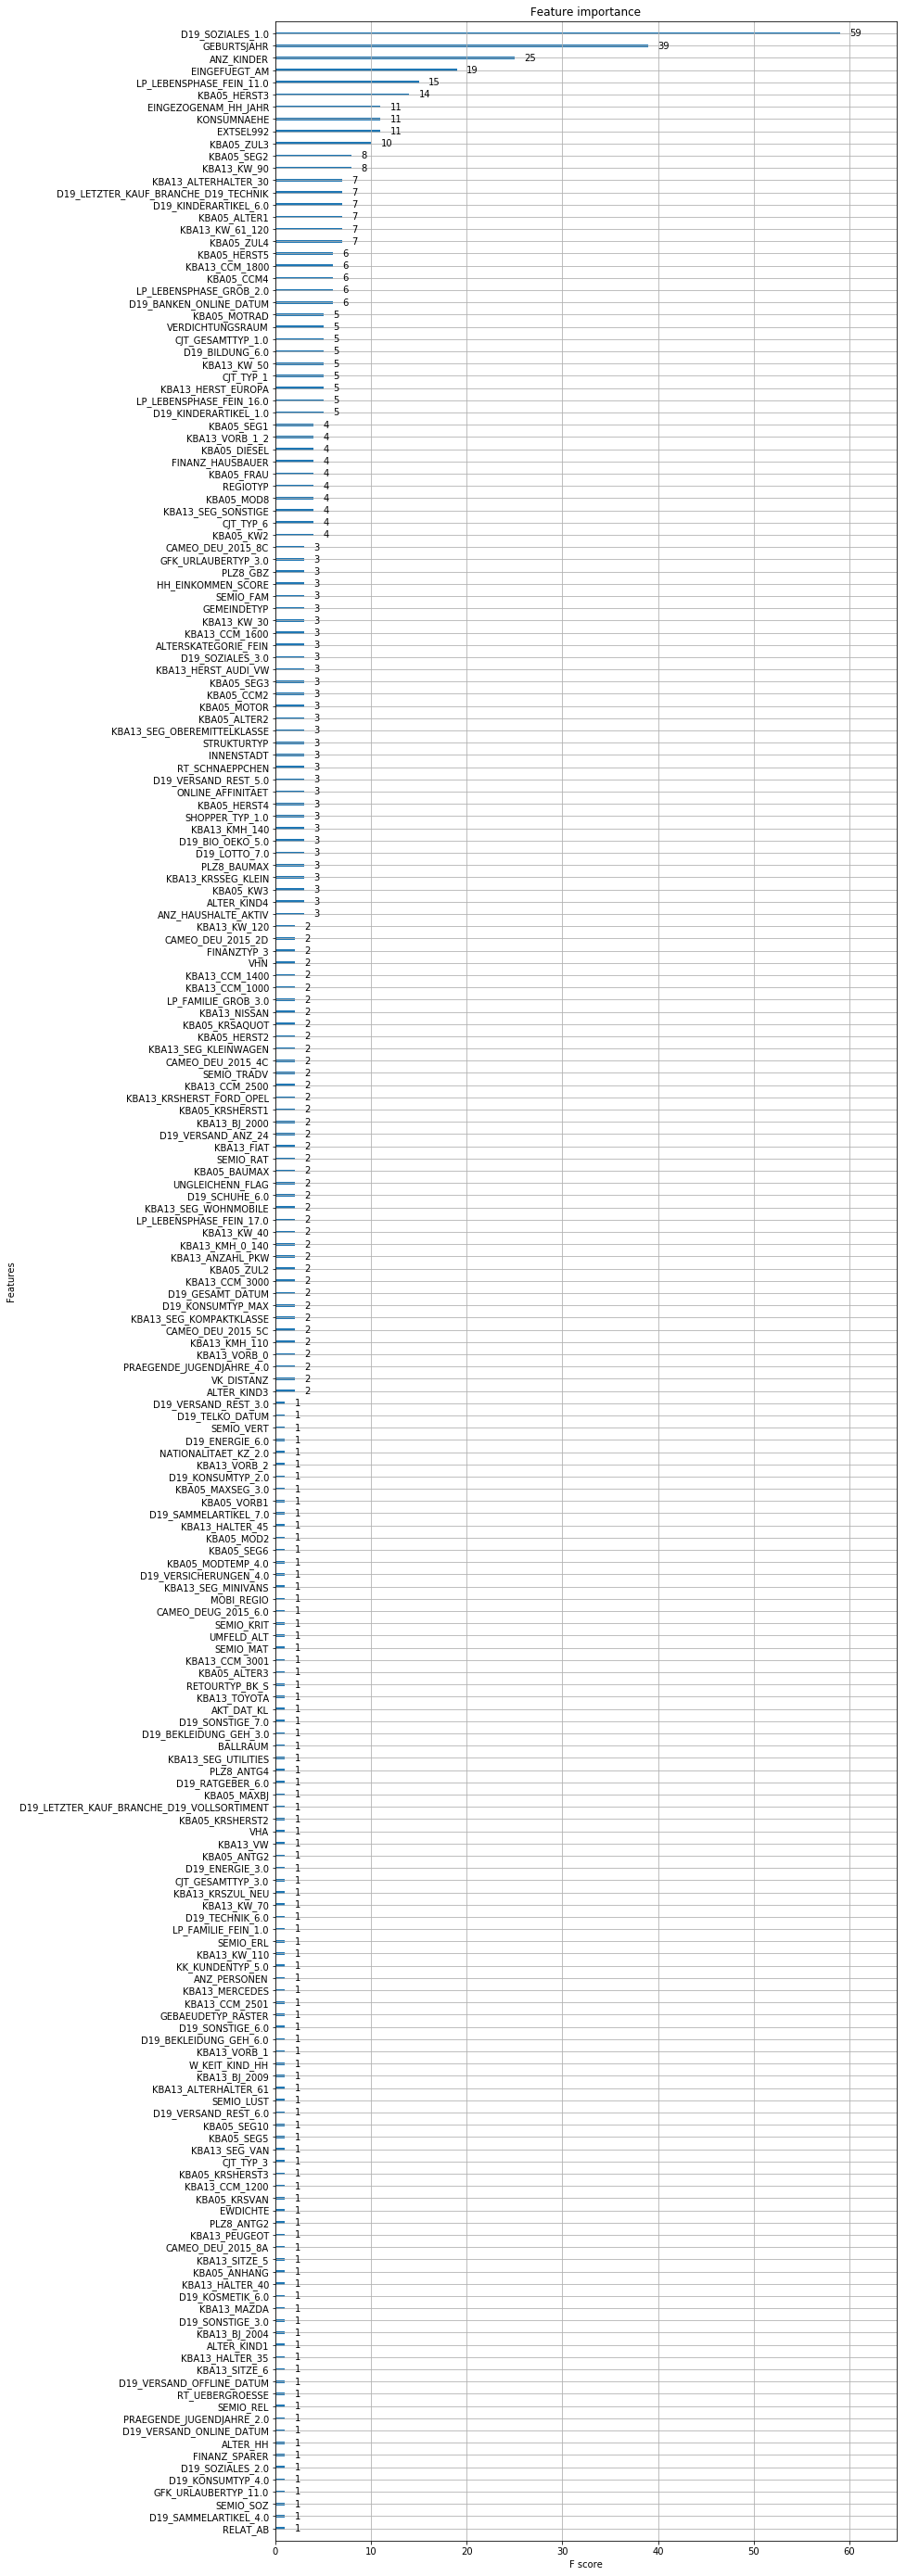

In [104]:
import xgboost as xgb
fig,ax=plt.subplots(figsize=(12,50))
xgb.plot_importance(clf,ax=ax)

### undocumented but important features

* D19_SOZIALES
* GEBURTSJAHR(known:year of birth)
* ANZ_KINDER
* EINGEFUEGT_AM(dt)
* LP_LEBENSPHASE_FEIN(known mixed:life stage)
* KBA05_HERST3(known: share of Ford/Opel)
* EINGEZOGENAM_HH_JAHR(year)
* KONSUMNAEHE(known:distance from a building to PoS (Point of Sale))
* EXTSEL992
* KBA05_ZUL3(known:share of cars built between 2001 and 2002)
* KBA05_SEG2(known:share of small and very small cars (Ford Fiesta, Ford Ka etc.) in the microcell)
* KBA13_KW_90(known:share of cars with an engine power between 81 and 90 KW - PLZ8)
* KBA13_ALTERHALTER_30(known:share of car owners below 31 within the PLZ8) 


The `response.csv` received a score of `0.80762` from Kaggle, which ranked top 3 on `Public Leaderboard` at the time of submission and very close to the Top Score `0.808`.